Web Scraping with Selectors
===================================================================

This exercise focuses on extracting data for S&P 500 companies from individual company pages on Wikipedia, with an emphasis on data consistency and error handling.

Wikipedia does have an API. For this exercise, we will pretend there is no API and simply read-in the HTML.

### 1. Create a Function to Scrape Company Infoboxes

We’ll start by building a function to gather information from each company's individual Wikipedia page. Choose a single company to begin, such as "[Apple Inc.](https://en.wikipedia.org/wiki/Apple_Inc.)." This page contains an infobox with information like CEO, revenue, and number of employees, which we want to extract.

a) Write a function called `get_company_info` which:
   - Takes a company’s Wikipedia URL as input.
   - Extracts the following fields from the infobox:
     - **Company Name**
     - **Industry**
     - **Revenue** (normalized to billions of USD if available)
     - **Net Income** (normalized to billions of USD if available)
     - **Number of Employees**
     - **Market Cap** (normalized to billions of USD if available)
   - Handles variability in field names if necessary. 
   - Make sure to handle exceptions gracefully.
   - Returns a dictionary with these fields as keys and the extracted data as values. If a field is missing, the function should return `None` for that entry.
   
Test `get_company_info` with the Apple Inc. page to verify it works and manages exceptions gracefully.

In [2]:
import requests
from bs4 import BeautifulSoup
import re

# Create a function to normalize values since we need it for 3 variables: Revenue, Net Income, Market Cap
def normalize_value(value):
    if 'billion' in value.lower(): # Convert BILLLION to lower-case
        # Extract number and convert to float
        number = float(re.findall(r'\d+\.?\d*', value)[0]) # e.g. include 123 or 123.456
        return number
    elif 'million' in value.lower(): # Convert MILLION to lower-case
        # Convert millions to billions
        number = float(re.findall(r'\d+\.?\d*', value)[0]) / 1000
        return number
    return value

# Write a function named `get_company_info`
def get_company_info(url):
    """
    Extracts detailed information about a company from its Wikipedia page infobox.

    The function takes a Wikipedia URL as input and parses the infobox to extract key company data. 
    The data is normalized and returned in a dictionary. If certain fields are not present, `None` is returned for those fields.

    Parameters:
    - url (str): The URL of the company's Wikipedia page.

    Returns:
    - dict: A dictionary containing the following keys:
      - 'Company Name': str or None
      - 'Industry': str or None
      - 'Revenue': float or None, normalized to billions of USD if possible
      - 'Net Income': float or None, normalized to billions of USD if possible
      - 'Number of Employees': int or None
      - 'Market Cap': float or None, normalized to billions of USD if possible

    The function handles exceptions gracefully and ensures that any missing data results in `None` values in the output dictionary.

    Example:
    --------
    To retrieve information for Apple Inc., call the function as follows:
    
    test_url = "https://en.wikipedia.org/wiki/Apple_Inc."
    company_info = get_company_info(test_url)
    print(company_info)
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # raise an exception for bad status
        soup = BeautifulSoup(response.content, 'html.parser')
        infobox = soup.find('table', {'class': re.compile(r'infobox')})

        # Create a dictionary to hold the data
        company_data = {
            'Company Name': None,
            'Industry': None,
            'Revenue': None,
            'Net Income': None,
            'Number of Employees': None,
            'Market Cap': None
        }

        # Get the company name separately since it is located outside the table
        company_name = soup.find('h1', {'id': 'firstHeading'}).get_text(strip=True)
        company_data['Company Name'] = company_name


        for row in infobox.find_all('tr'): # starts a loop over each table row (<tr>) in the infobox
            header = row.find('th') # find the first table header (<th>) in the row, which typically contains the data field's name (e.g. "Revenue", "Net Income")
            if header: # if header is not NONE
                header_text = header.text.strip().lower() # get the text inside and remove any leading or trailing whitespace
                data = row.find('td') # For each row, find table data cell (<td>)
                if data:

                    # To deal with problem that Wikipedia lists different industries in separate line
                    if 'industry' in header_text:
                        # Extracting text from each <li> element and joining them with a comma
                        industry_items = data.find_all('li')
                        if industry_items:  # Check if there are any <li> elements
                            industry_texts = [item.get_text(strip=True) for item in industry_items]
                            formatted_industry = ', '.join(industry_texts)
                        else:
                            # Fallback to use the direct text content if no <li> tags are present
                            formatted_industry = data.get_text(strip=True)
                        company_data['Industry'] = formatted_industry
                        
                    elif 'revenue' in header_text:
                        company_data['Revenue'] = normalize_value(data.get_text(strip=True))
                    elif 'net income' in header_text:
                        company_data['Net Income'] = normalize_value(data.get_text(strip=True))
                    elif 'number of employees' in header_text:
                        #substitute non-digit part into space and extract only digit.
                        company_data['Number of Employees'] = int(re.sub(r'[^0-9]', '', data.get_text(strip=True).split('(')[0])) # split the part by '(' and only include the first half e.g. 164,000 (2024) becomes 164000
                    elif 'market cap' in header_text:
                        company_data['Market Cap'] = normalize_value(data.get_text(strip=True))

        return company_data
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

NOTE: We cannot get market cap since it is not listed in the page. Wikipedia only have Operating income, Net income, Total assets, and Total equity. These values cannot get us Market Cap. To calculate Market Cap, we need numebr of outstanding shares and share price. Yahoo finance may be a better option than Wikipedia.

In [3]:
# Test `get_company_info` with the Apple Inc. page to verify it works and manages exceptions gracefully
test_url = "https://en.wikipedia.org/wiki/Apple_Inc."
get_company_info(test_url)

{'Company Name': 'Apple Inc.',
 'Industry': 'Consumer electronics, Software services, Online services',
 'Revenue': 391.04,
 'Net Income': 93.74,
 'Number of Employees': 164000,
 'Market Cap': None}

b) Expand the function to gather information on key people in the company. Specifically, add the following fields:
   - **CEO**
   - **Founder(s)**
   - **Founded** (year)

Make sure you parse the HTML for the `Founder(s)` field to get the actual names as a comma separated string. For the CEO, parse the HTML for the key people section and identify the CEO. Add these fields to the dictionary returned by the function.

Test the function with the Apple Inc. page to verify it works and manages exceptions gracefully.


In [ ]:
import re

# Create a function to clean my data (do not want name with '[]' e.g. CEO: 'William [3]')
def clean_text(text):
    """
    Removes text within square brackets and additional whitespace.

    Parameters:
    - text (str): The original text to be cleaned.

    Returns:
    - str: Cleaned text.
    """
    # Remove any text inside square brackets (including the brackets)
    cleaned_text = re.sub(r'\[\s*\d+\s*\]', '', text)
    # Strip any leading/trailing whitespace
    return cleaned_text.strip()

# Function to get CEO name
def extract_ceo(data):
    """
    Extracts the CEO's name from a specific section of a Wikipedia infobox.

    This function searches through text elements within a BeautifulSoup object
    to find an entry that indicates the person is a CEO. It handles cases where
    the CEO title is combined with other titles.

    Parameters:
    - data (BeautifulSoup): A BeautifulSoup object corresponding to a <td> HTML element
      that may contain one or more text nodes or <li> elements.

    Returns:
    - str or None: The name of the CEO if found; otherwise, None.
    """
    if data.find('li'):
        items = data.find_all('li')
    else:
        items = [data]  # Treat the entire <td> as one item if no <li> tags

    ceo_name = None
    for item in items:
        text = item.get_text(" ", strip=True)
        if 'CEO' in text:
            patterns = [
                r"(.+?)\s+\(.*CEO.*\)",  # Matches: 'Name (some text CEO some text)'
                r"(.+?)\s+-.*CEO.*"      # Matches: 'Name - some text CEO some text'
            ]
            for pattern in patterns:
                match = re.search(pattern, text)
                if match:
                    ceo_name = clean_text(match.group(1))
                    break
        if ceo_name:
            break

    return ceo_name

In [24]:
# Create a function to deal problem that Wikipedia lists different industries/founders in separate line
def extract_list_data(data):
    """
    Extracts text from list elements or direct content from the data cell.

    Parameters:
    - data (BeautifulSoup): A BeautifulSoup object corresponding to a <td> HTML element
      that may contain one or more <li> elements.

    Returns:
    - str: A comma-separated string of the text content from each <li> element if present,
           otherwise the direct text content of the data.
    """
    items = data.find_all('li')
    if items:  # Check if there are any <li> elements
        item_texts = [item.get_text(strip=True) for item in items]
        return ', '.join(item_texts)
    else:
        # Fallback to use the direct text content if no <li> tags are present
        return data.get_text(strip=True)

In [25]:
import requests
from bs4 import BeautifulSoup
import re

# Create a function to normalize values since we need it for 3 variables: Revenue, Net Income, Market Cap
def normalize_value(value):
    if 'billion' in value.lower(): # Convert BILLLION to lower-case
        # Extract number and convert to float
        number = float(re.findall(r'\d+\.?\d*', value)[0]) # e.g. include 123 or 123.456
        return number
    elif 'million' in value.lower(): # Convert MILLION to lower-case
        # Convert millions to billions
        number = float(re.findall(r'\d+\.?\d*', value)[0]) / 1000
        return number
    return value

# Add additional code for the function named `get_company_info`
def get_company_info(url):
    """
    Extracts detailed information about a company from its Wikipedia page infobox.

    The function takes a Wikipedia URL as input and parses the infobox to extract key company data. 
    The data is normalized and returned in a dictionary. If certain fields are not present, `None` is returned for those fields.

    Parameters:
    - url (str): The URL of the company's Wikipedia page.

    Returns:
    - dict: A dictionary containing the following keys:
      - 'Company Name': str or None
      - 'Industry': str or None
      - 'Revenue': float or None, normalized to billions of USD if possible
      - 'Net Income': float or None, normalized to billions of USD if possible
      - 'Number of Employees': int or None
      - 'Market Cap': float or None, normalized to billions of USD if possible
      - 'CEO': int or None
      - 'Founder(s)': int or None
      - 'Founded': float or None, unit in year(s)

    The function handles exceptions gracefully and ensures that any missing data results in `None` values in the output dictionary.

    Example:
    --------
    To retrieve information for Apple Inc., call the function as follows:
    
    test_url = "https://en.wikipedia.org/wiki/Apple_Inc."
    company_info = get_company_info(test_url)
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # raise an exception for bad status
        soup = BeautifulSoup(response.content, 'html.parser')
        infobox = soup.find('table', {'class': re.compile(r'infobox')})

        # Create a dictionary to hold the data
        company_data = {
            'Company Name': None,
            'Industry': None,
            'Revenue': None,
            'Net Income': None,
            'Number of Employees': None,
            'Market Cap': None,
            'CEO': None,
            'Founder(s)': None,
            'Founded': None
        }

        # Get the company name separately since it is located outside the table
        company_name = soup.find('h1', {'id': 'firstHeading'}).get_text(strip=True)
        company_data['Company Name'] = company_name


        for row in infobox.find_all('tr'): # starts a loop over each table row (<tr>) in the infobox
            header = row.find('th') # find the first table header (<th>) in the row, which typically contains the data field's name (e.g. "Revenue", "Net Income")
            if header: # if header is not NONE
                header_text = header.text.strip().lower() # get the text inside and remove any leading or trailing whitespace
                data = row.find('td') # For each row, find table data cell (<td>)
                if data:

                    # Code industry and founder together to deal with the problem that Wikipedia lists different industries/founder in separate line
                    if 'industry' in header_text or 'founder' in header_text or 'founders' in header_text:
                        company_data['Industry' if 'industry' in header_text else 'Founder(s)'] = clean_text(extract_list_data(data))
                        
                    elif 'revenue' in header_text:
                        company_data['Revenue'] = normalize_value(data.get_text(strip=True))
                    elif 'net income' in header_text:
                        company_data['Net Income'] = normalize_value(data.get_text(strip=True))
                    elif 'number of employees' in header_text:
                        #substitute non-digit part into space and extract only digit.
                        company_data['Number of Employees'] = int(re.sub(r'[^0-9]', '', data.get_text(strip=True).split('(')[0])) # split the part by '(' and only include the first half e.g. 164,000 (2024) becomes 164000
                    elif 'market cap' in header_text:
                        company_data['Market Cap'] = normalize_value(data.get_text(strip=True))

                    # Capture CEO, Founders, and Founded year
                    elif 'key people' in header_text:
                        company_data['CEO'] = extract_ceo(data) # Note: here we cannot input "data.get_text(strip=True)"
                    elif 'founded' in header_text:
                        founded_year = re.search(r'\d{4}', data.get_text(strip=True))
                        if founded_year:
                            company_data['Founded'] = founded_year.group(0)

        return company_data
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
# Test `get_company_info` with the Apple Inc. page to verify it works and manages exceptions gracefully
test_url = "https://en.wikipedia.org/wiki/Apple_Inc."
display(get_company_info(test_url))

{'Company Name': 'Apple Inc.',
 'Industry': 'Consumer electronics, Software services, Online services',
 'Revenue': 391.04,
 'Net Income': 93.74,
 'Number of Employees': 164000,
 'Market Cap': None,
 'CEO': 'Tim Cook',
 'Founder(s)': 'Steve Jobs, Steve Wozniak, Ronald Wayne',
 'Founded': '1976'}

### 2. Retrieve S&P 500 Table

Navigate to the Wikipedia page with the full list of S&P 500 companies: [List of S&P 500 companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). This page contains a table with general information about each company.

a) Write code to scrape this table and create a `pandas` DataFrame with the following columns:
   - **Company Name**
   - **Link to Company Wikipedia page**
   - **GICS Sector**
   - **GICS Sub-Industry**
   - **Headquarters Location**
   
Display the first five rows of the DataFrame.

In [26]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

def fetch_sp500_companies():
    """
    Fetches the S&P 500 companies table from Wikipedia and returns it as a pandas DataFrame.
    
    Returns:
    - DataFrame: A DataFrame with columns for the Company Name, Link to Wikipedia page,
                 GICS Sector, GICS Sub-Industry, and Headquarters Location.
    """

    # Access web content and parse
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the first table on the page which contains the S&P 500 companies
    table = soup.find('table', {'id': 'constituents'}) # 'constituents'is the HTML element containing the data of the S&P 500 companies on the Wikipedia page.

    # Initialize lists to hold the data
    companies = []
    links = []
    sectors = []
    sub_industries = []
    headquarters = []

    # Iterate over each row in the table except for the header row
    for row in table.find('tbody').find_all('tr')[1:]: # skip the first row of variable names. For the rest, each row corresponds to a company in the S&P 500 list
        cells = row.find_all('td') # collect data cell
        companies.append(cells[1].text.strip()) # company name is located in the second cell
        links.append("https://en.wikipedia.org" + cells[1].find('a').get('href')) # links are obtained by finding an <a> tag within this cell and appending its 'href' attribute to the base Wikipedia URL
        sectors.append(cells[3].text.strip())
        sub_industries.append(cells[4].text.strip())
        headquarters.append(cells[5].text.strip())

    # Create the DataFrame
    df = pd.DataFrame({
        'Company Name': companies,
        'Link to Wikipedia Page': links,
        'GICS Sector': sectors,
        'GICS Sub-Industry': sub_industries,
        'Headquarters Location': headquarters
    })

    return df

# Fetch the S&P 500 companies data and display the first five rows of the DataFrame
sp500_df = fetch_sp500_companies()
sp500_df.head()


,Company Name,Link to Wikipedia Page,GICS Sector,GICS Sub-Industry,Headquarters Location
0,3M,https://en.wikipedia.org/wiki/3M,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04
1,A. O. Smith,https://en.wikipedia.org/wiki/A._O._Smith,Building Products,"Milwaukee, Wisconsin",2017-07-26
2,Abbott Laboratories,https://en.wikipedia.org/wiki/Abbott_Laboratories,Health Care Equipment,"North Chicago, Illinois",1957-03-04
3,AbbVie,https://en.wikipedia.org/wiki/AbbVie,Biotechnology,"North Chicago, Illinois",2012-12-31
4,Accenture,https://en.wikipedia.org/wiki/Accenture,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06


### 3. Add Detailed Information to the S&P 500 DataFrame

Using the `get_company_info` function you created, retrieve additional data for each company in the list:

a) Loop through each company in the DataFrame from the previous step, accessing its individual Wikipedia page to get the detailed infobox data, and add it as new columns to your main DataFrame. Once complete, export your updated DataFrame with the additional columns to a CSV.



NOTE: One of the companies, Insulet Corporation, does not have a valid Wikipage. So I encountered one error in the below code. Check https://en.wikipedia.org/wiki/Insulet_Corporation and you will see the below picture

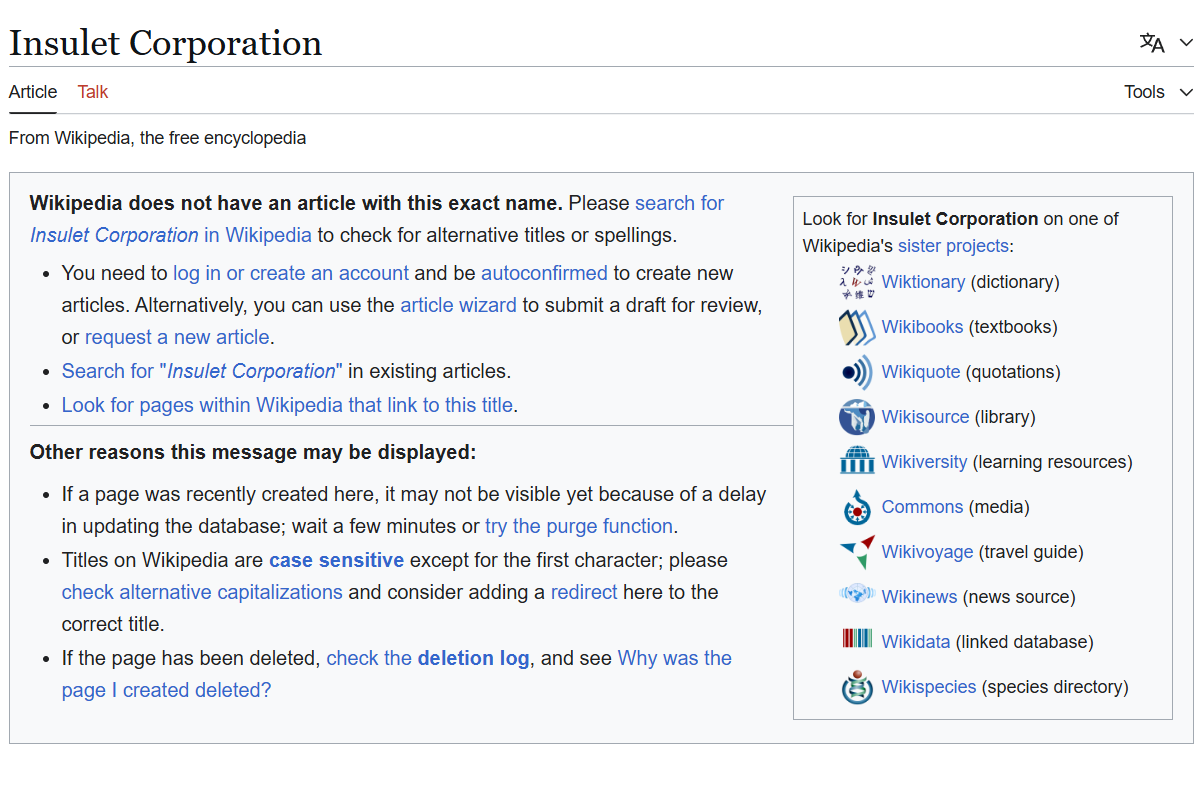

In [28]:
# Create a function to loop through each company in the DataFrame
def add_detailed_info_to_sp500(df):
    """
    Enhances the S&P 500 companies DataFrame with additional detailed information for each company
    and exports the updated DataFrame to a CSV file.
    
    Parameters:
    - df (DataFrame): A DataFrame containing basic information of S&P 500 companies.
    
    Returns:
    - DataFrame: The enhanced DataFrame with additional columns for detailed company information.
    """
    # Initialize columns for additional data based on what get_company_info returns
    columns_of_interest = ['Industry', 'Revenue', 'Net Income', 'Number of Employees', 'Market Cap','CEO', 'Founder(s)', 'Founded']
    for col in columns_of_interest:
        df[col] = None  # Initialize new columns with None

    # Iterate over each company to fetch additional details
    for index, row in df.iterrows():
        # Fetch detailed info from the company's Wikipedia page
        info = get_company_info(row['Link to Wikipedia Page'])
        if info:  # If info is not None
            for col in columns_of_interest:
                if col in info:  # Check if the key exists in the dictionary returned from get_company_info
                    df.at[index, col] = info[col] #at method allows fast access to a single value and is ideal for setting values based on an index-label identification

    return df

# Fetch the S&P 500 companies data
sp500_df = fetch_sp500_companies()
# Add detailed information to the S&P 500 DataFrame
detailed_sp500_df = add_detailed_info_to_sp500(sp500_df)
# Display the first 5 rows with detailed info
display(detailed_sp500_df.head())

# Save the updated DataFrame to a CSV file
detailed_sp500_df.to_csv('sp500_detailed_info.csv', index=False)

An error occurred: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Insulet_Corporation


,Company Name,Link to Wikipedia Page,GICS Sector,GICS Sub-Industry,Headquarters Location,Industry,Revenue,Net Income,Number of Employees,Market Cap,CEO,Founder(s),Founded
0,3M,https://en.wikipedia.org/wiki/3M,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,Conglomerate,32.68,6.99,85000,None,William M. Brown,"J. Danley Budd, Henry S. Bryan, William A. McG...",1902
1,A. O. Smith,https://en.wikipedia.org/wiki/A._O._Smith,Building Products,"Milwaukee, Wisconsin",2017-07-26,Water technology,2.9,0.37,151005,None,Kevin J. Wheeler,Charles Jeremiah Smith,1874
2,Abbott Laboratories,https://en.wikipedia.org/wiki/Abbott_Laboratories,Health Care Equipment,"North Chicago, Illinois",1957-03-04,"Health care, Medical devices, Pharmaceutical",40.1,5.72,114000,None,None,Wallace Calvin Abbott,1888
3,AbbVie,https://en.wikipedia.org/wiki/AbbVie,Biotechnology,"North Chicago, Illinois",2012-12-31,Biopharmaceutical,54.32,4.873,50000,None,Robert Michael,None,2012
4,Accenture,https://en.wikipedia.org/wiki/Accenture,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,"Professional services, Information technology ...",64.9,7.42,774000,None,Julie Sweet,None,1989
